In [1]:
pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


In [2]:
import Augmentor

In [6]:
train_directory="/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/training_set"

In [5]:
p = Augmentor.Pipeline("/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/training_set",output_directory="/kaggle/working/output")

Initialised with 281 image(s) found.
Output directory set to /kaggle/working/output.

In [7]:
p1 = Augmentor.Pipeline("/kaggle/input/glaucoma-dataset4/RIM-ONE_DL_images/partitioned_by_hospital/test_set",output_directory="/kaggle/working/output1")


Initialised with 164 image(s) found.
Output directory set to /kaggle/working/output1.

In [8]:
#Step 3 Define the Operations
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p.sample(800)

Processing <PIL.Image.Image image mode=RGB size=438x438 at 0x7D9218462DD0>: 100%|██████████| 800/800 [01:01<00:00, 12.96 Samples/s]                


In [9]:
#Step 3 Define the Operations
p1.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p1.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p1.sample(800)

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=393x393 at 0x7D9219548850>: 100%|██████████| 800/800 [00:37<00:00, 21.42 Samples/s]


In [10]:
import pathlib
import tensorflow as tf

data_dir_Training= pathlib.Path('/kaggle/working/output')
data_dir_Testing= pathlib.Path('/kaggle/working/output1')

img_height=224
img_width=224

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
train_ds  = tf.keras.utils.image_dataset_from_directory(
  data_dir_Training,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 800 files belonging to 2 classes.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_Testing,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=32)

Found 800 files belonging to 2 classes.


In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0072462666 0.59341586


In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D,Conv2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model = ResNet50(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model.layers[:10]:
    layer.trainable = False
x = base_model.output
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(2, activation='softmax')(x)
model1 = Model(inputs=base_model.inputs, outputs=predictions)

94765736/94765736 [==============================] - 3s 0us/step


In [18]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model1 = DenseNet201(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model1.layers[:10]:
    layer.trainable = False
x = base_model1.output
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model1.inputs, outputs=predictions)

74836368/74836368 [==============================] - 3s 0us/step


In [19]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D,Conv2D,Dense,Dropout
base_model2 = InceptionV3(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False)
# Freeze the first 10 layers
for layer in base_model2.layers[:10]:
    layer.trainable = False
x = base_model2.output
x = Conv2D(128,(3,3),activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation='softmax')(x)
model3 = Model(inputs=base_model2.inputs, outputs=predictions)

87910968/87910968 [==============================] - 3s 0us/step


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath1 = "/kaggle/working/My Drive/ResNet50-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint1 = ModelCheckpoint(
    filepath=model_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath2 = "/kaggle/working/My Drive/DenseNet201-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint2 = ModelCheckpoint(
    filepath=model_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath3 = "/kaggle/working/My Drive/InceptionV3-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint3 = ModelCheckpoint(
    filepath=model_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [30]:
model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [31]:
model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [32]:
model3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [33]:
history1=model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,callbacks=[checkpoint1])

Epoch 1/5
25/25 [==============================] - ETA: 0s - loss: 0.3383 - accuracy: 0.9050
Epoch 1: val_accuracy improved from -inf to 0.33250, saving model to /kaggle/working/My Drive/ResNet50-01-0.3325.hdf5
25/25 [==============================] - 40s 304ms/step - loss: 0.3383 - accuracy: 0.9050 - val_loss: 142.2459 - val_accuracy: 0.3325
Epoch 2/5
25/25 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9212
Epoch 2: val_accuracy improved from 0.33250 to 0.38375, saving model to /kaggle/working/My Drive/ResNet50-02-0.3837.hdf5
25/25 [==============================] - 6s 256ms/step - loss: 0.2419 - accuracy: 0.9212 - val_loss: 24.6229 - val_accuracy: 0.3837
Epoch 3/5
25/25 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9362
Epoch 3: val_accuracy did not improve from 0.38375
25/25 [==============================] - 5s 217ms/step - loss: 0.1734 - accuracy: 0.9362 - val_loss: 17926.2148 - val_accuracy: 0.3325
Epoch 4/5
25/25 [=============

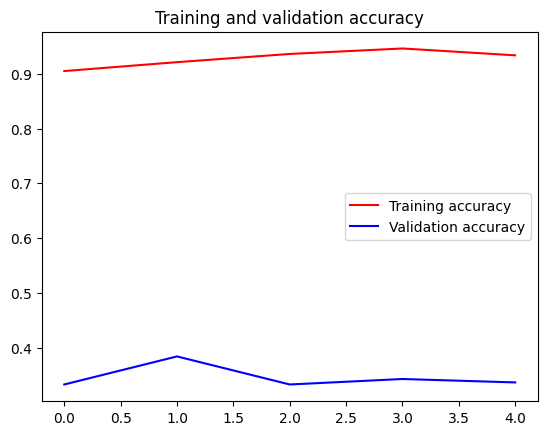

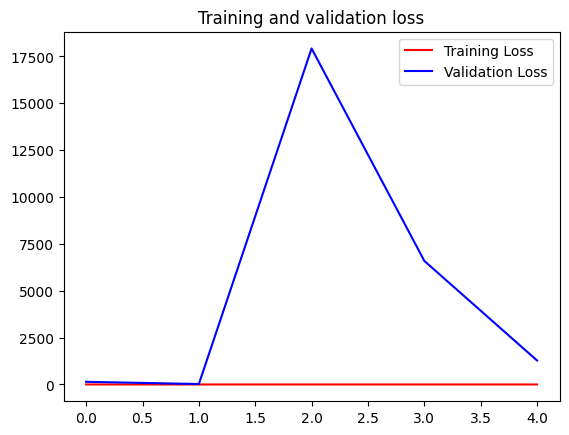

In [34]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
history2=model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,callbacks=[checkpoint2])

Epoch 1/5
25/25 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.7763
Epoch 1: val_accuracy improved from -inf to 0.33250, saving model to /kaggle/working/My Drive/DenseNet201-01-0.3325.hdf5
25/25 [==============================] - 123s 588ms/step - loss: 0.6644 - accuracy: 0.7763 - val_loss: 221.1032 - val_accuracy: 0.3325
Epoch 2/5
25/25 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.9212
Epoch 2: val_accuracy improved from 0.33250 to 0.63250, saving model to /kaggle/working/My Drive/DenseNet201-02-0.6325.hdf5
25/25 [==============================] - 11s 449ms/step - loss: 0.2554 - accuracy: 0.9212 - val_loss: 4.1366 - val_accuracy: 0.6325
Epoch 3/5
25/25 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.9400
Epoch 3: val_accuracy did not improve from 0.63250
25/25 [==============================] - 9s 361ms/step - loss: 0.1557 - accuracy: 0.9400 - val_loss: 15.5635 - val_accuracy: 0.3613
Epoch 4/5
25/25 [=========

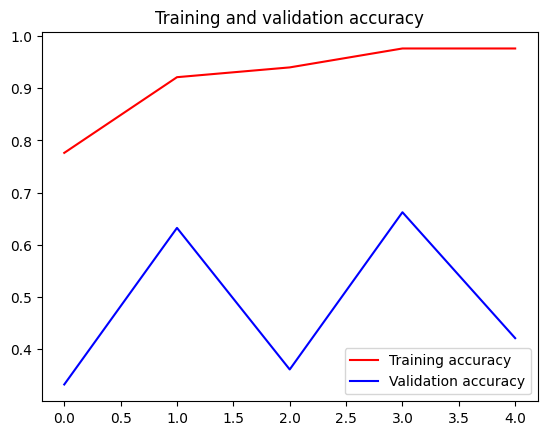

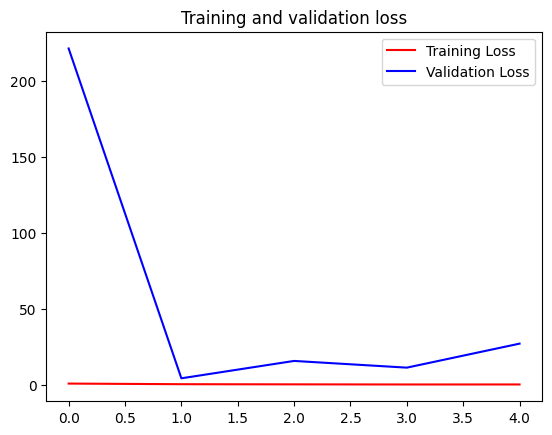

In [36]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
history3=model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,callbacks=[checkpoint3])

Epoch 1/5
25/25 [==============================] - ETA: 0s - loss: 0.9435 - accuracy: 0.6300
Epoch 1: val_accuracy improved from -inf to 0.66750, saving model to /kaggle/working/My Drive/InceptionV3-01-0.6675.hdf5
25/25 [==============================] - 40s 276ms/step - loss: 0.9435 - accuracy: 0.6300 - val_loss: 259.2544 - val_accuracy: 0.6675
Epoch 2/5
25/25 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.8000
Epoch 2: val_accuracy did not improve from 0.66750
25/25 [==============================] - 4s 172ms/step - loss: 0.4454 - accuracy: 0.8000 - val_loss: 1.5408 - val_accuracy: 0.4487
Epoch 3/5
25/25 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.8863
Epoch 3: val_accuracy did not improve from 0.66750
25/25 [==============================] - 4s 172ms/step - loss: 0.2714 - accuracy: 0.8863 - val_loss: 2.3793 - val_accuracy: 0.6662
Epoch 4/5
25/25 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.8925
Epoch 4: 

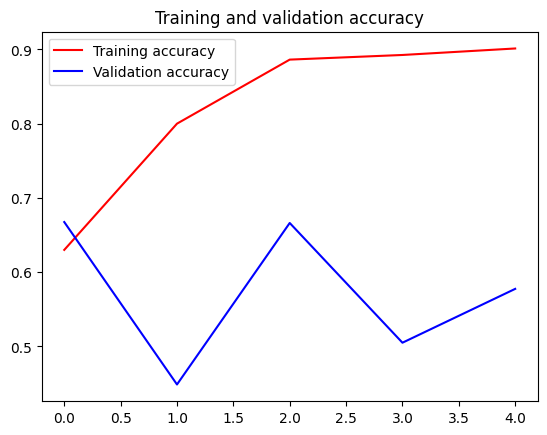

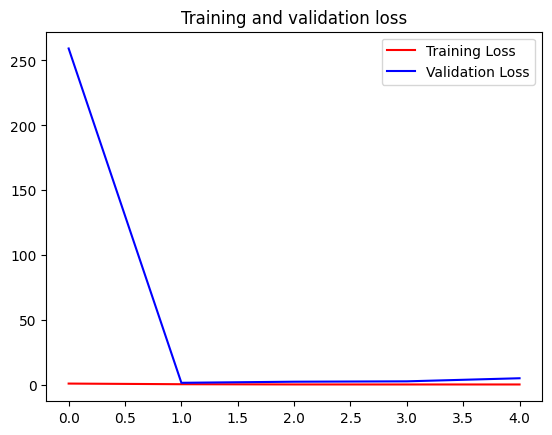

In [38]:
import matplotlib.pyplot as plt
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
import numpy as np
model_1 = load_model('/kaggle/working/My Drive/ResNet50-02-0.3837.hdf5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='ResNet50')
model_2 = load_model('/kaggle/working/My Drive/DenseNet201-04-0.6625.hdf5')
model_2 = Model(inputs=model_2.inputs,
             outputs=model_2.outputs,
              name='DenseNet202')
model_3 = load_model('/kaggle/working/My Drive/InceptionV3-01-0.6675.hdf5')
model_3 = Model(inputs=model_3.inputs,
             outputs=model_3.outputs,
              name='InceptionV3')
models = [model_1, model_2,model_3]



#w = np.array([0.7, 0.9])
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]

#ensemble = VotingClassifier(estimators=models, weights=w, voting='soft')
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [40]:
import tensorflow as tf
ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [41]:
history=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10)

Epoch 1/10
25/25 [==============================] - 195s 962ms/step - loss: 0.3537 - accuracy: 0.8363 - val_loss: 1.0676 - val_accuracy: 0.6675
Epoch 2/10
25/25 [==============================] - 18s 730ms/step - loss: 0.3716 - accuracy: 0.8612 - val_loss: 0.6359 - val_accuracy: 0.6675
Epoch 3/10
25/25 [==============================] - 18s 730ms/step - loss: 0.4678 - accuracy: 0.8300 - val_loss: 0.6359 - val_accuracy: 0.6675
Epoch 4/10
25/25 [==============================] - 18s 729ms/step - loss: 0.4054 - accuracy: 0.8487 - val_loss: 0.6359 - val_accuracy: 0.6675
Epoch 5/10
25/25 [==============================] - 18s 729ms/step - loss: 0.4138 - accuracy: 0.8238 - val_loss: 0.6359 - val_accuracy: 0.6675
Epoch 6/10
25/25 [==============================] - 18s 729ms/step - loss: 0.3644 - accuracy: 0.8550 - val_loss: 0.6412 - val_accuracy: 0.6600
Epoch 7/10
25/25 [==============================] - 18s 730ms/step - loss: 0.3539 - accuracy: 0.8612 - val_loss: 0.8681 - val_accuracy: 0.332

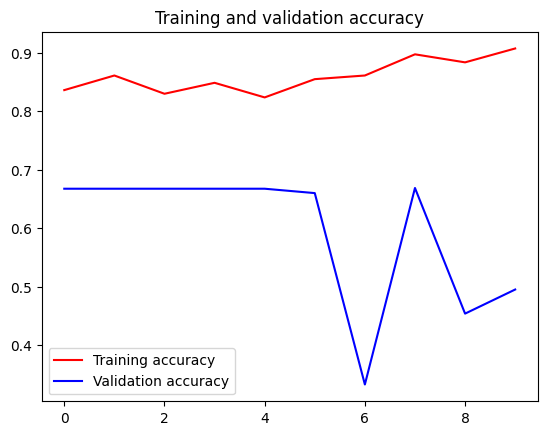

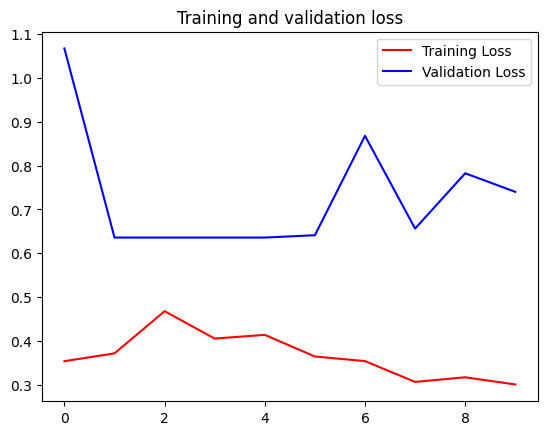

In [42]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:

train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(800,)
(800,)


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(val_ds, 2132)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['normal','glaucoma']
print(classification_report(test_label, y_pred, target_names=target_names))




/tmp/ipykernel_47/2841421654.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 2132)


Confusion Matrix
[[259   7]
 [397 137]]
Classification Report
              precision    recall  f1-score   support

      normal       0.39      0.97      0.56       266
    glaucoma       0.95      0.26      0.40       534

    accuracy                           0.49       800
   macro avg       0.67      0.62      0.48       800
weighted avg       0.77      0.49      0.46       800



In [ ]:
import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names,yticklabels=target_names,fmt='')
#sns.heatmap(cm, annot=True,annot_kws={"size": 22})
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');

In [45]:
history1=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15)

Epoch 1/15
25/25 [==============================] - 18s 731ms/step - loss: 0.3095 - accuracy: 0.9125 - val_loss: 0.7938 - val_accuracy: 0.4275
Epoch 2/15
25/25 [==============================] - 18s 731ms/step - loss: 0.3874 - accuracy: 0.8737 - val_loss: 0.6980 - val_accuracy: 0.5788
Epoch 3/15
25/25 [==============================] - 18s 729ms/step - loss: 0.3435 - accuracy: 0.9000 - val_loss: 0.7688 - val_accuracy: 0.4762
Epoch 4/15
25/25 [==============================] - 18s 730ms/step - loss: 0.2690 - accuracy: 0.9262 - val_loss: 0.7165 - val_accuracy: 0.5813
Epoch 5/15
25/25 [==============================] - 18s 729ms/step - loss: 0.2794 - accuracy: 0.9300 - val_loss: 0.7815 - val_accuracy: 0.5775
Epoch 6/15
25/25 [==============================] - 18s 730ms/step - loss: 0.3486 - accuracy: 0.8700 - val_loss: 0.7633 - val_accuracy: 0.5125
Epoch 7/15
25/25 [==============================] - 19s 768ms/step - loss: 0.2841 - accuracy: 0.9112 - val_loss: 0.6073 - val_accuracy: 0.6488

In [46]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(800,)
(800,)


In [47]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(val_ds, 2132)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['normal','glaucoma']
print(classification_report(test_label, y_pred, target_names=target_names))



/tmp/ipykernel_47/2968483857.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 2132)


Confusion Matrix
[[239  27]
 [342 192]]
Classification Report
              precision    recall  f1-score   support

      normal       0.41      0.90      0.56       266
    glaucoma       0.88      0.36      0.51       534

    accuracy                           0.54       800
   macro avg       0.64      0.63      0.54       800
weighted avg       0.72      0.54      0.53       800



In [48]:
history1=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25)

Epoch 1/25
25/25 [==============================] - 18s 731ms/step - loss: 0.1951 - accuracy: 0.9538 - val_loss: 1.4029 - val_accuracy: 0.6100
Epoch 2/25
25/25 [==============================] - 18s 732ms/step - loss: 0.2436 - accuracy: 0.9438 - val_loss: 1.2244 - val_accuracy: 0.6750
Epoch 3/25
25/25 [==============================] - 18s 733ms/step - loss: 0.2207 - accuracy: 0.9400 - val_loss: 1.5027 - val_accuracy: 0.5188
Epoch 4/25
25/25 [==============================] - 18s 733ms/step - loss: 0.2157 - accuracy: 0.9300 - val_loss: 0.8896 - val_accuracy: 0.6812
Epoch 5/25
25/25 [==============================] - 18s 734ms/step - loss: 0.2766 - accuracy: 0.9337 - val_loss: 1.0756 - val_accuracy: 0.6062
Epoch 6/25
25/25 [==============================] - 18s 739ms/step - loss: 0.2536 - accuracy: 0.9013 - val_loss: 0.9764 - val_accuracy: 0.5800
Epoch 7/25
25/25 [==============================] - 18s 737ms/step - loss: 0.2680 - accuracy: 0.9038 - val_loss: 1.5546 - val_accuracy: 0.6600

In [49]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(800,)
(800,)


In [50]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(val_ds, 2132)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['normal','glaucoma']
print(classification_report(test_label, y_pred, target_names=target_names))


/tmp/ipykernel_47/1188923234.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 2132)


Confusion Matrix
[[234  32]
 [384 150]]
Classification Report
              precision    recall  f1-score   support

      normal       0.38      0.88      0.53       266
    glaucoma       0.82      0.28      0.42       534

    accuracy                           0.48       800
   macro avg       0.60      0.58      0.47       800
weighted avg       0.68      0.48      0.46       800



In [51]:
from tensorflow.keras.callbacks import EarlyStopping
# Assuming you've defined your model and datasets (train_ds, val_ds)

# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with early stopping
history3 = ensemble_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping]
)


Epoch 1/30
25/25 [==============================] - 20s 795ms/step - loss: 0.1674 - accuracy: 0.9675 - val_loss: 1.6376 - val_accuracy: 0.6475
Epoch 2/30
25/25 [==============================] - 18s 734ms/step - loss: 0.1475 - accuracy: 0.9725 - val_loss: 2.1046 - val_accuracy: 0.6700
Epoch 3/30
25/25 [==============================] - 18s 735ms/step - loss: 0.1448 - accuracy: 0.9750 - val_loss: 2.1917 - val_accuracy: 0.6450
Epoch 4/30
25/25 [==============================] - 18s 734ms/step - loss: 0.1455 - accuracy: 0.9737 - val_loss: 3.9740 - val_accuracy: 0.5600
Epoch 5/30
25/25 [==============================] - 18s 734ms/step - loss: 0.1474 - accuracy: 0.9688 - val_loss: 3.4198 - val_accuracy: 0.5813
Epoch 6/30
25/25 [==============================] - 19s 768ms/step - loss: 0.1314 - accuracy: 0.9812 - val_loss: 3.7267 - val_accuracy: 0.5337


In [52]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis=0) 
print(test_label.shape)

(800,)
(800,)


In [53]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(val_ds, 2132)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['normal','glaucoma']
print(classification_report(test_label, y_pred, target_names=target_names))


/tmp/ipykernel_47/1188923234.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(val_ds, 2132)


Confusion Matrix
[[205  61]
 [221 313]]
Classification Report
              precision    recall  f1-score   support

      normal       0.48      0.77      0.59       266
    glaucoma       0.84      0.59      0.69       534

    accuracy                           0.65       800
   macro avg       0.66      0.68      0.64       800
weighted avg       0.72      0.65      0.66       800

